In [8]:
# Download Trained model

from file_downloader import FileDownloader

downloader = FileDownloader(data_directory='../data')

url = "https://mf-data-analytics.s3.eu-west-1.amazonaws.com/nyc_crime_category_random_forest_model_150_15.pkl"
filename = "nyc_crime_category_random_forest_model_150_15.pkl"
model_file_path = downloader.download_file(url, filename)


File downloaded successfully and saved to ../data/nyc_crime_category_random_forest_model_150_15.pkl


In [9]:
# check for required file

import os
from pathlib import Path

DATA_FILE_PATH = '../data/NYPD_Complaint_Data_Historic_Cleaned_Reduced_Merged.csv'

file_path = Path(DATA_FILE_PATH)

# Check if the file exists
if file_path.exists():
    print(f"File found: {file_path}")
else:
    print(f"File not found: {file_path}. Please ensure the file is downloaded correctly.")

File found: ../data/NYPD_Complaint_Data_Historic_Cleaned_Reduced_Merged.csv


Model loaded from ../data/nyc_crime_category_random_forest_model_150_15.pkl


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   10.2s finished


Accuracy: 0.4047
Classification Report:


/Users/markfinlay/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/markfinlay/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/markfinlay/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                          precision    recall  f1-score   support

       Drug and Alcohol-Related Offenses       0.00      0.00      0.00       677
            Family and Personal Offenses       0.34      0.21      0.26     93209
              Fraud and Financial Crimes       0.00      0.00      0.00      3651
     Miscellaneous and Specific Offenses       0.57      0.00      0.00     40589
            Negligence and Careless Acts       0.00      0.00      0.00        38
                         Property Crimes       1.00      0.00      0.00     29818
Public Order and Administrative Offenses       0.70      0.00      0.00     35945
                       Theft and Larceny       0.41      0.72      0.52    133822
                                 Traffic       0.93      0.01      0.01      7309
                          Violent Crimes       0.42      0.59      0.49    130277
          Weapons and Dangerous Offenses       0.00      0.00      0.00      1302

              

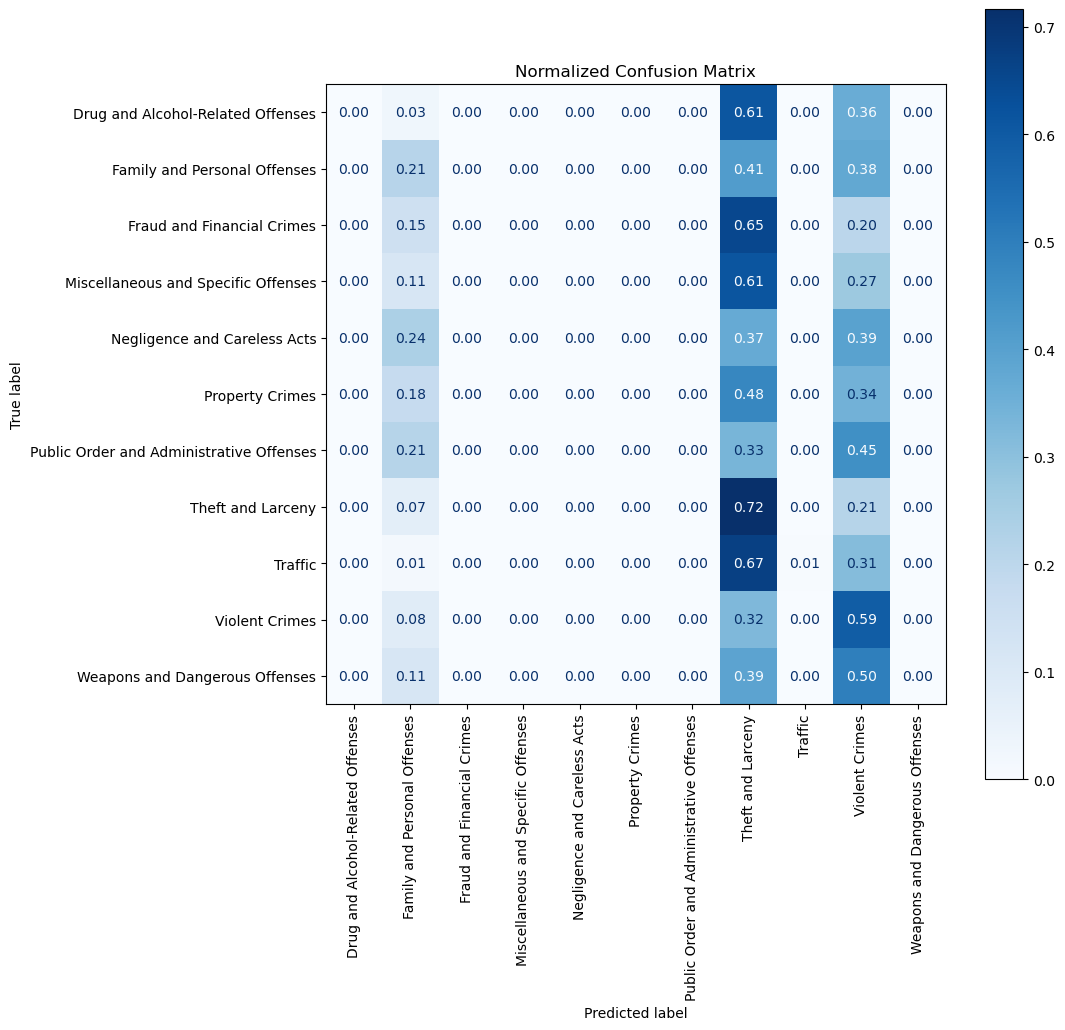

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from nyc_crime_category_random_forest_model import NycCrimeCategoryRandomForestModel

# Initialize the model with optional parameters so we can retrieve Test Data
model = NycCrimeCategoryRandomForestModel(
    random_state=42,
    test_size=0.30,
    n_estimators=30,
    max_depth=3,
    drop_columns=['OFNS_DESC', 'OFNS_DESC_Severity_Score'],
    target_column='Crime_Category',
    model_filename='',
    verbose_level=1
)

model.load_data(DATA_FILE_PATH)
model.preprocess_data()
model.split_data()

X_test = model.X_test

model.load_model(model_file_path)
y_pred = model.predict(X_test)

# Assuming you have the true labels from the test set (y_test)
# If not, you may need to split the data beforehand or ensure you have the true labels.
y_test = model.y_test

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=model.label_encoder.classes_))

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix by row (i.e., by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=model.label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
plt.xticks(rotation=90)
plt.title('Normalized Confusion Matrix')
plt.show()



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   10.7s finished


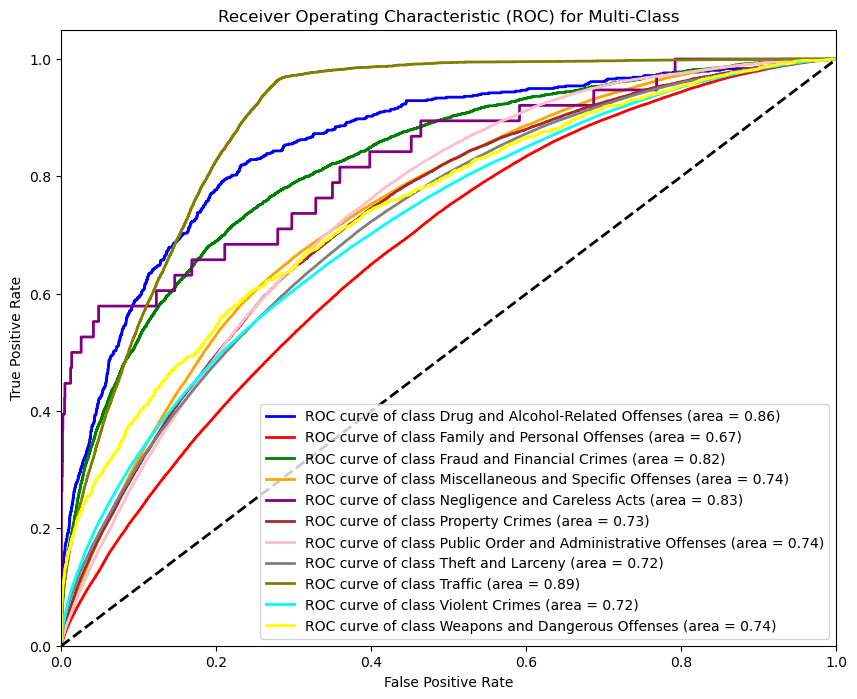

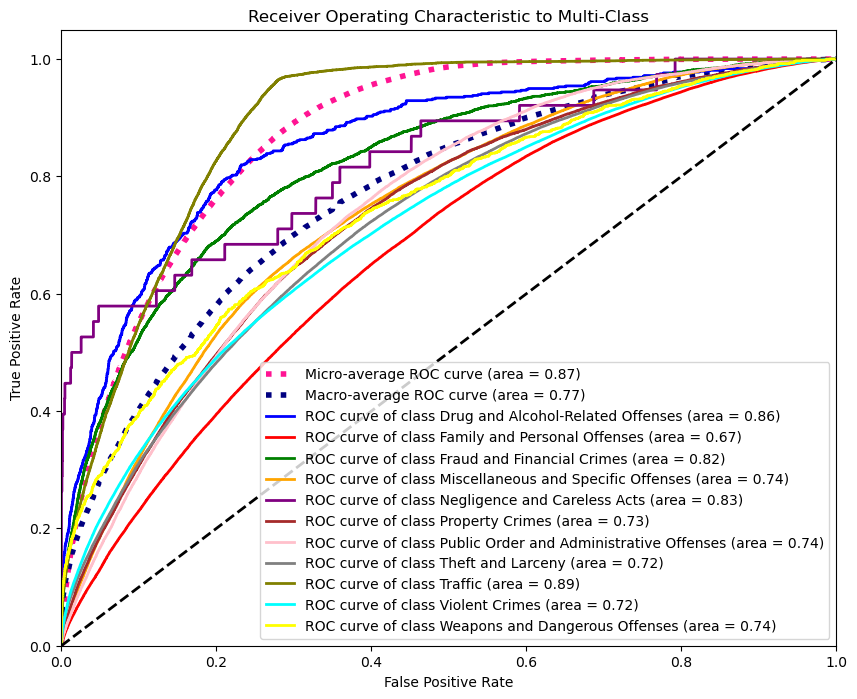

In [13]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Binarize the labels for multi-class ROC AUC
y_test_bin = label_binarize(y_test, classes=range(len(model.label_encoder.classes_)))

# Get the prediction probabilities from the model
y_score = model.pipeline.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot of a ROC curve for a specific class
plt.figure(figsize=(10, 8))

colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'yellow']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {model.label_encoder.classes_[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multi-Class')
plt.legend(loc="lower right")
plt.show()


# Micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle=':', linewidth=4,
         label='Macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(model.label_encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic to Multi-Class')
plt.legend(loc="lower right")
plt.show()

